Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 2.2903, Accuracy: 12.71%, Validation: Loss: 2.2520, Accuracy: 14.36%
Epoch [2/70] Training: Loss: 2.1709, Accuracy: 18.99%, Validation: Loss: 2.0732, Accuracy: 25.16%
Epoch [3/70] Training: Loss: 1.9967, Accuracy: 27.20%, Validation: Loss: 1.9374, Accuracy: 29.54%
Epoch [4/70] Training: Loss: 1.8891, Accuracy: 31.42%, Validation: Loss: 1.8410, Accuracy: 33.39%
Epoch [5/70] Training: Loss: 1.7885, Accuracy: 35.48%, Validation: Loss: 1.7920, Accuracy: 34.44%
Epoch [6/70] Training: Loss: 1.7113, Accuracy: 38.50%, Validation: Loss: 1.7138, Accuracy: 38.23%
Epoch [7/70] Training: Loss: 1.6467, Accuracy: 40.64%, Validation: Loss: 1.6311, Accuracy: 40.58%
Epoch [8/70] Training: Loss: 1.5909, Accuracy: 42.66%, Validation: Loss: 1.5974, Accuracy: 42.25%
Epoch [9/70] Training: Loss: 1.5420, Accuracy: 44.38%, Validation: Loss: 1.5606, Accuracy: 43.62%
Epoch [10/70] Training: Loss: 1.5042, Accu

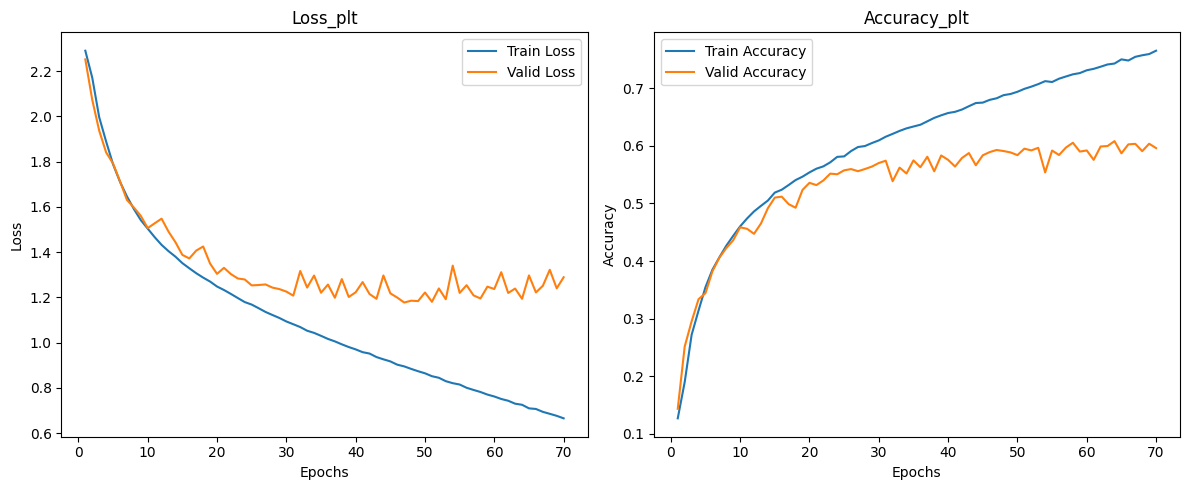

In [4]:
# LeNet
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

# 定义 LeNet 模型
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=2)  # 第一层卷积
        self.pool = nn.AvgPool2d(2, 2)  # 平均池化层
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)  # 第二层卷积
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 第一个全连接层
        self.fc2 = nn.Linear(120, 84)  # 第二个全连接层
        self.fc3 = nn.Linear(84, 10)  # 输出层，对应10个类别

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 6 * 6)  # 展平处理
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 超参数
batch_size = 128
lr = 0.01
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
all_start = time.time() # 计时结束
train(epochs)
test()
all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 1.5697, Accuracy: 41.92%, Validation: Loss: 1.3102, Accuracy: 52.47%
Epoch [2/70] Training: Loss: 1.1981, Accuracy: 56.73%, Validation: Loss: 1.1354, Accuracy: 59.34%
Epoch [3/70] Training: Loss: 1.0476, Accuracy: 62.75%, Validation: Loss: 0.9942, Accuracy: 63.92%
Epoch [4/70] Training: Loss: 0.9516, Accuracy: 66.37%, Validation: Loss: 0.9207, Accuracy: 66.90%
Epoch [5/70] Training: Loss: 0.8736, Accuracy: 69.19%, Validation: Loss: 0.8622, Accuracy: 69.22%
Epoch [6/70] Training: Loss: 0.8228, Accuracy: 71.04%, Validation: Loss: 0.8483, Accuracy: 70.27%
Epoch [7/70] Training: Loss: 0.7667, Accuracy: 72.84%, Validation: Loss: 0.7365, Accuracy: 74.62%
Epoch [8/70] Training: Loss: 0.7337, Accuracy: 74.27%, Validation: Loss: 0.7399, Accuracy: 73.80%
Epoch [9/70] Training: Loss: 0.6987, Accuracy: 75.31%, Validation: Loss: 0.7123, Accuracy: 75.04%
Epoch [10/70] Training: Loss: 0.6771, Accu

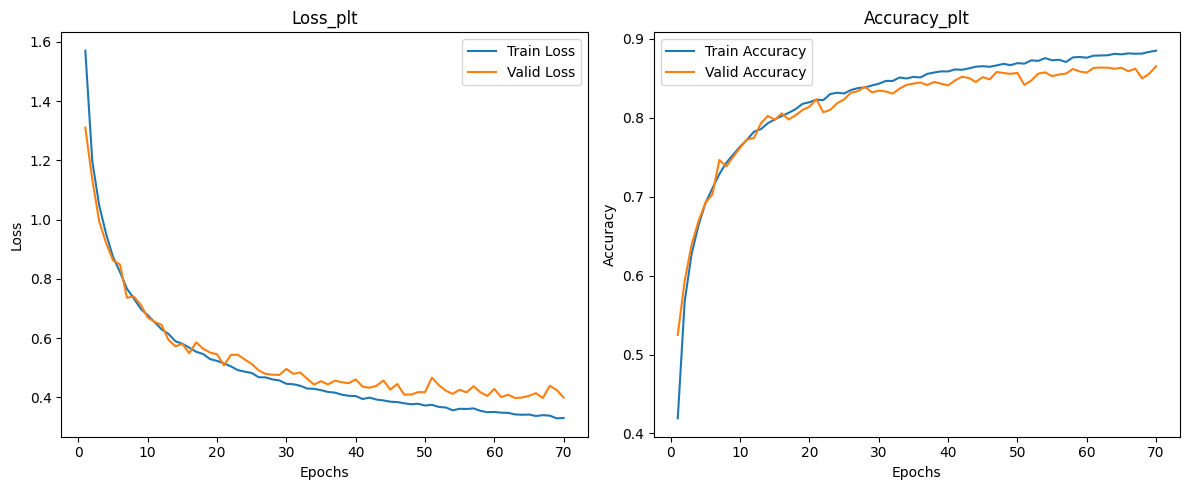

In [ ]:
#数据增强    base采用正则化明显的res dropout 0.5 + bn + weightdecay
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 添加归一化层
        
        # 用于调整输入和输出的维度
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)  # 应用归一化
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)  # 应用归一化
        return self.relu(out + self.shortcut(x))  # 残差

# 带有残差连接的 AlexNet 模型
class RRRR(nn.Module):
    def __init__(self):
        super(RRRR, self).__init__()
        self.features = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(192, 384),
            ResidualBlock(384, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((1, 1))  # 使用自适应平均池化
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 64),  # 修改全连接层输入尺寸
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # 添加 dropout 层
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256)  # 修改展平后的尺寸
        x = self.classifier(x)
        return x

# 超参数
batch_size = 128
lr = 0.001
epochs = 70
weight_decay = 1e-4  # 添加权重衰减


class Cutout(object):
    def __init__(self, num_holes, max_h_size, max_w_size):
        self.num_holes = num_holes
        self.max_h_size = max_h_size
        self.max_w_size = max_w_size

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.num_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.max_h_size // 2, 0, h)
            y2 = np.clip(y + self.max_h_size // 2, 0, h)
            x1 = np.clip(x - self.max_w_size // 2, 0, w)
            x2 = np.clip(x + self.max_w_size // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

# transform 
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    Cutout(num_holes=1, max_h_size=8, max_w_size=8),  #  Cutout 数据增强
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)  # 使用权重衰减
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

all_start = time.time() # 计时结束
train(epochs)
test()
all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 1.7883, Accuracy: 32.07%, Validation: Loss: 1.4182, Accuracy: 46.61%
Epoch [2/70] Training: Loss: 1.2705, Accuracy: 53.02%, Validation: Loss: 1.1921, Accuracy: 58.22%
Epoch [3/70] Training: Loss: 1.0546, Accuracy: 62.15%, Validation: Loss: 0.9508, Accuracy: 65.74%
Epoch [4/70] Training: Loss: 0.8948, Accuracy: 67.86%, Validation: Loss: 0.8659, Accuracy: 69.30%
Epoch [5/70] Training: Loss: 0.7976, Accuracy: 71.80%, Validation: Loss: 0.8256, Accuracy: 70.87%
Epoch [6/70] Training: Loss: 0.7297, Accuracy: 74.26%, Validation: Loss: 0.7156, Accuracy: 74.89%
Epoch [7/70] Training: Loss: 0.6523, Accuracy: 77.19%, Validation: Loss: 0.6647, Accuracy: 76.90%
Epoch [8/70] Training: Loss: 0.6170, Accuracy: 78.42%, Validation: Loss: 0.6597, Accuracy: 77.80%
Epoch [9/70] Training: Loss: 0.5760, Accuracy: 79.67%, Validation: Loss: 0.6691, Accuracy: 77.35%
Epoch [10/70] Training: Loss: 0.5456, Accu

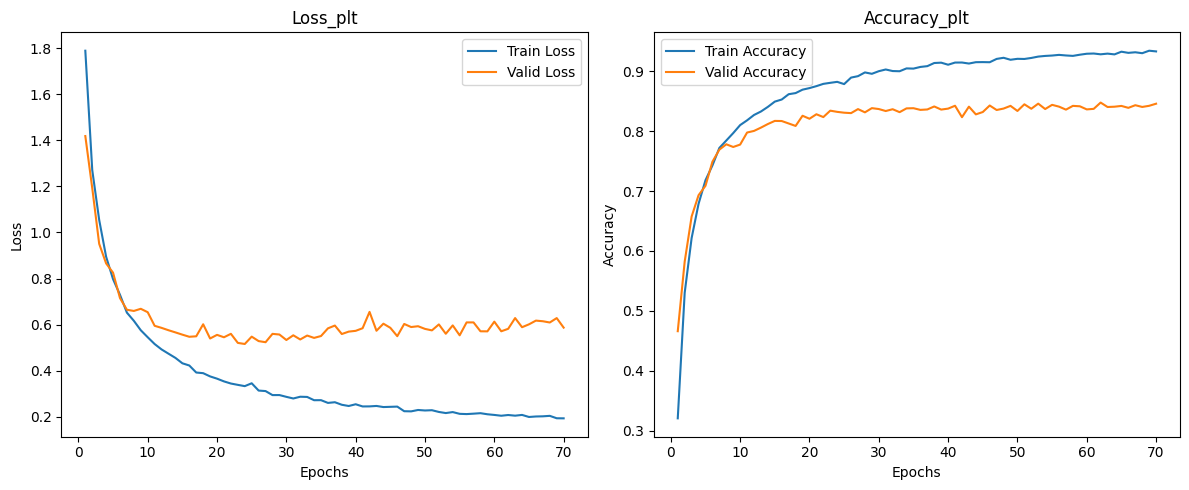

In [7]:
# 基于Alex改造的resnet Adam + 无正则
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        
        # 用于调整输入和输出的维度
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        return self.relu(out + self.shortcut(x))  # 残差连接

# 带有残差连接的 AlexNet 模型
class AlexNetWithResiduals(nn.Module):
    def __init__(self):
        super(AlexNetWithResiduals, self).__init__()
        self.features = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(192, 384),
            ResidualBlock(384, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),  # 修改全连接层输入尺寸
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)  # 修改展平后的尺寸
        x = self.classifier(x)
        return x
    
# 超参数
batch_size = 128
lr = 0.001
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetWithResiduals().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
all_start = time.time() # 计时
train(epochs)
test()
all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 1.5120, Accuracy: 44.20%, Validation: Loss: 1.7140, Accuracy: 45.17%
Epoch [2/70] Training: Loss: 1.0077, Accuracy: 64.52%, Validation: Loss: 0.9406, Accuracy: 67.54%
Epoch [3/70] Training: Loss: 0.7998, Accuracy: 72.16%, Validation: Loss: 0.8956, Accuracy: 69.75%
Epoch [4/70] Training: Loss: 0.6693, Accuracy: 77.00%, Validation: Loss: 0.6777, Accuracy: 77.18%
Epoch [5/70] Training: Loss: 0.5832, Accuracy: 80.07%, Validation: Loss: 0.7368, Accuracy: 75.10%
Epoch [6/70] Training: Loss: 0.5114, Accuracy: 82.64%, Validation: Loss: 0.6440, Accuracy: 78.16%
Epoch [7/70] Training: Loss: 0.4634, Accuracy: 84.23%, Validation: Loss: 0.6745, Accuracy: 78.80%
Epoch [8/70] Training: Loss: 0.4125, Accuracy: 85.88%, Validation: Loss: 0.5199, Accuracy: 82.65%
Epoch [9/70] Training: Loss: 0.3719, Accuracy: 87.43%, Validation: Loss: 0.4916, Accuracy: 84.26%
Epoch [10/70] Training: Loss: 0.3367, Accu

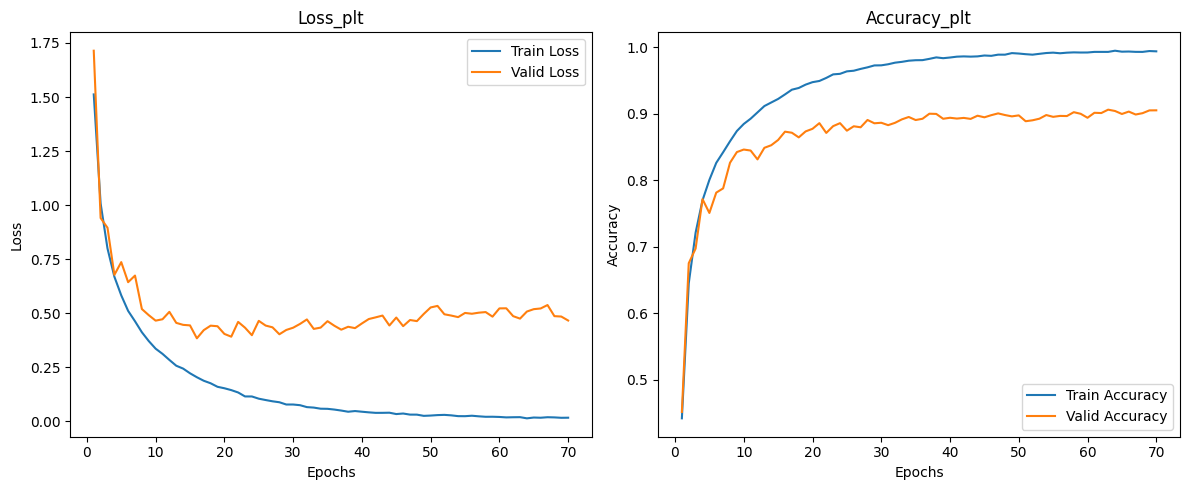

In [8]:
# 基于Alex改造的resnet + dropout + bn
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 添加归一化层
        
        # 用于调整输入和输出的维度
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)  # 应用归一化
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)  # 应用归一化
        return self.relu(out + self.shortcut(x))  # 残差

# 带有残差连接的 AlexNet 模型
class AlexNetWithResiduals(nn.Module):
    def __init__(self):
        super(AlexNetWithResiduals, self).__init__()
        self.features = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(192, 384),
            ResidualBlock(384, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),  # 修改全连接层输入尺寸
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),  # 添加 dropout 层
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),  # 添加 dropout 层
            nn.Linear(2048, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)  # 修改展平后的尺寸
        x = self.classifier(x)
        return x
# 超参数
batch_size = 128
lr = 0.01
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetWithResiduals().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
all_start = time.time() # 计时
train(epochs)
test()
all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()



Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 1.4992, Accuracy: 44.58%, Validation: Loss: 1.2953, Accuracy: 54.99%
Epoch [2/70] Training: Loss: 1.0025, Accuracy: 64.41%, Validation: Loss: 0.9306, Accuracy: 66.92%
Epoch [3/70] Training: Loss: 0.7923, Accuracy: 72.44%, Validation: Loss: 0.8140, Accuracy: 71.74%
Epoch [4/70] Training: Loss: 0.6667, Accuracy: 77.03%, Validation: Loss: 0.6986, Accuracy: 76.88%
Epoch [5/70] Training: Loss: 0.5854, Accuracy: 80.04%, Validation: Loss: 0.6302, Accuracy: 78.66%
Epoch [6/70] Training: Loss: 0.5097, Accuracy: 82.71%, Validation: Loss: 0.6630, Accuracy: 77.68%
Epoch [7/70] Training: Loss: 0.4609, Accuracy: 84.34%, Validation: Loss: 0.6135, Accuracy: 79.40%
Epoch [8/70] Training: Loss: 0.4258, Accuracy: 85.54%, Validation: Loss: 0.4813, Accuracy: 83.98%
Epoch [9/70] Training: Loss: 0.3801, Accuracy: 87.02%, Validation: Loss: 0.4756, Accuracy: 84.53%
Epoch [10/70] Training: Loss: 0.3481, Accu

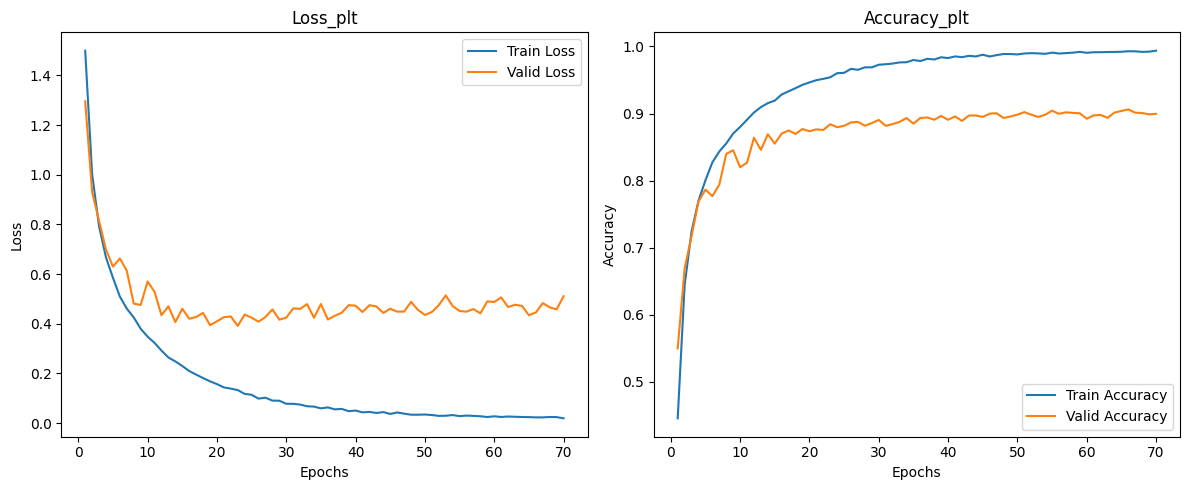

In [2]:
# 基于Alex改造的resnet + dropout + bn + weight decay(SGD)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 添加归一化层
        
        # 用于调整输入和输出的维度
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)  # 应用归一化
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)  # 应用归一化
        return self.relu(out + self.shortcut(x))  # 残差

# 带有残差连接的 AlexNet 模型
class AlexNetWithResiduals(nn.Module):
    def __init__(self):
        super(AlexNetWithResiduals, self).__init__()
        self.features = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(192, 384),
            ResidualBlock(384, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),  # 修改全连接层输入尺寸
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),  # 添加 dropout 层
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),  # 添加 dropout 层
            nn.Linear(2048, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)  # 修改展平后的尺寸
        x = self.classifier(x)
        return x
# 超参数
batch_size = 128
lr = 0.01
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetWithResiduals().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,  weight_decay=1e-4)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
all_start = time.time() # 计时
train(epochs)
test()
all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 2.2268, Accuracy: 19.42%, Validation: Loss: 1.7898, Accuracy: 29.76%
Epoch [2/70] Training: Loss: 1.6141, Accuracy: 39.16%, Validation: Loss: 1.3719, Accuracy: 48.93%
Epoch [3/70] Training: Loss: 1.2818, Accuracy: 54.17%, Validation: Loss: 1.1292, Accuracy: 59.30%
Epoch [4/70] Training: Loss: 1.0676, Accuracy: 62.48%, Validation: Loss: 1.0386, Accuracy: 63.19%
Epoch [5/70] Training: Loss: 0.9272, Accuracy: 67.84%, Validation: Loss: 0.9568, Accuracy: 67.46%
Epoch [6/70] Training: Loss: 0.8144, Accuracy: 72.08%, Validation: Loss: 0.8006, Accuracy: 71.99%
Epoch [7/70] Training: Loss: 0.7191, Accuracy: 75.59%, Validation: Loss: 0.8077, Accuracy: 72.67%
Epoch [8/70] Training: Loss: 0.6487, Accuracy: 78.39%, Validation: Loss: 0.7180, Accuracy: 75.53%
Epoch [9/70] Training: Loss: 0.5876, Accuracy: 80.56%, Validation: Loss: 0.6669, Accuracy: 78.26%
Epoch [10/70] Training: Loss: 0.5504, Accu

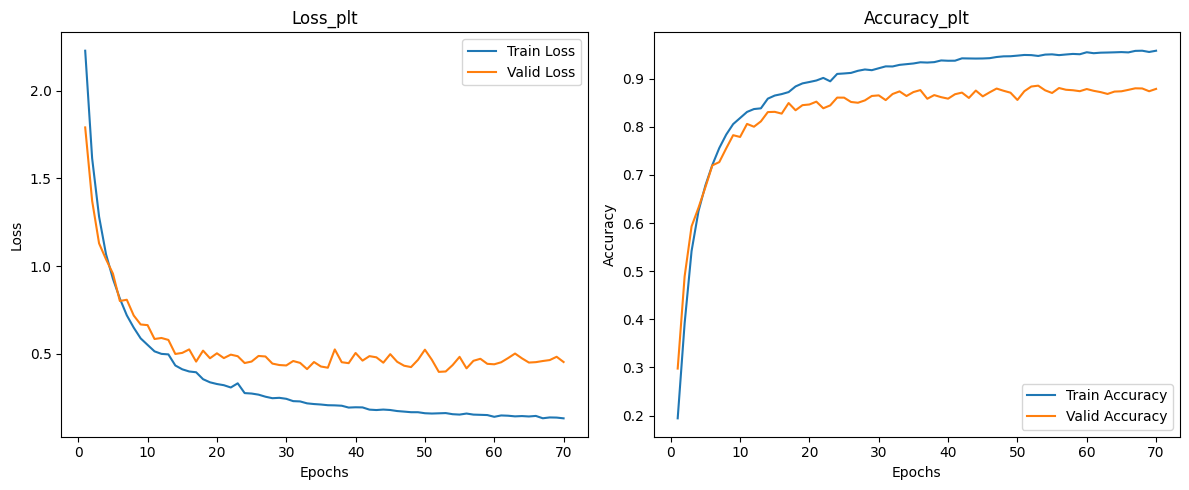

In [6]:
# L2正则 + 基于Alex改造的resnet + dropout（比率up） + bn
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 添加归一化层
        
        # 用于调整输入和输出的维度
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)  # 应用归一化
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)  # 应用归一化
        return self.relu(out + self.shortcut(x))  # 残差

# 带有残差连接的 AlexNet 模型
class RRR(nn.Module):
    def __init__(self):
        super(RRR, self).__init__()
        self.features = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(192, 384),
            ResidualBlock(384, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((1, 1))  # 使用自适应平均池化，输出为 (256, 1, 1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 1024),  # 修改全连接层输入尺寸
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # 添加 dropout 层
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 )  # 修改展平后的尺寸
        x = self.classifier(x)
        return x
# 超参数
batch_size = 128
lr = 0.001
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RRR().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-4)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
all_start = time.time() # 计时
train(epochs)
test()
all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 2.0929, Accuracy: 17.15%, Validation: Loss: 1.8696, Accuracy: 22.98%
Epoch [2/70] Training: Loss: 1.9204, Accuracy: 21.16%, Validation: Loss: 1.6821, Accuracy: 34.07%
Epoch [3/70] Training: Loss: 1.8096, Accuracy: 25.65%, Validation: Loss: 1.6750, Accuracy: 34.85%
Epoch [4/70] Training: Loss: 1.7632, Accuracy: 27.62%, Validation: Loss: 1.5588, Accuracy: 38.93%
Epoch [5/70] Training: Loss: 1.7175, Accuracy: 29.38%, Validation: Loss: 1.5072, Accuracy: 40.89%
Epoch [6/70] Training: Loss: 1.6517, Accuracy: 32.59%, Validation: Loss: 1.4836, Accuracy: 44.76%
Epoch [7/70] Training: Loss: 1.5474, Accuracy: 39.36%, Validation: Loss: 1.3272, Accuracy: 51.33%
Epoch [8/70] Training: Loss: 1.4253, Accuracy: 45.83%, Validation: Loss: 1.2430, Accuracy: 56.62%
Epoch [9/70] Training: Loss: 1.2745, Accuracy: 52.94%, Validation: Loss: 1.0793, Accuracy: 62.33%
Epoch [10/70] Training: Loss: 1.1426, Accu

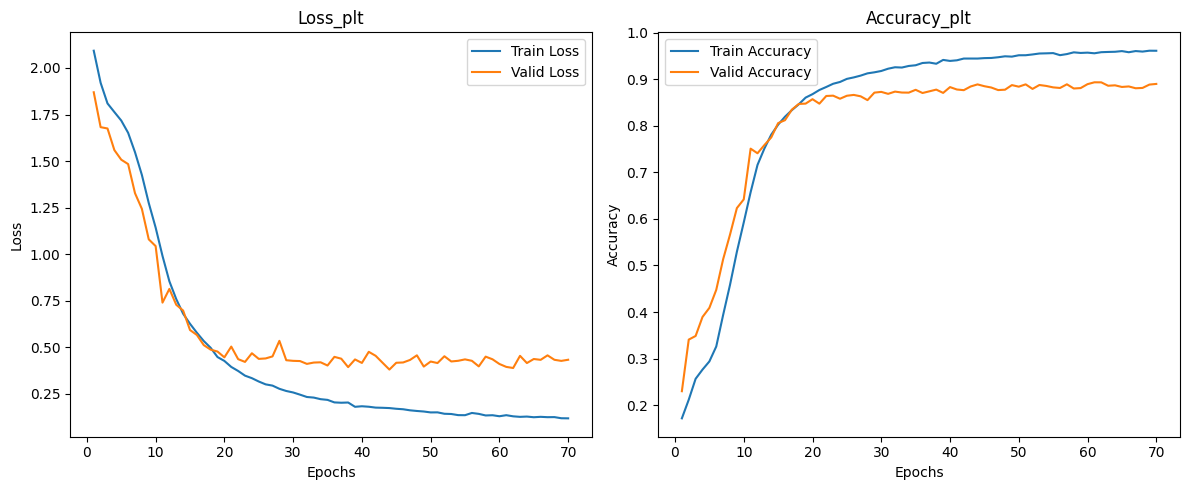

In [7]:
# 使用数据增强   base基于Alex改造的resnet + dropout + bn 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 添加归一化层
        
        # 用于调整输入和输出的维度
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)  # 应用归一化
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)  # 应用归一化
        return self.relu(out + self.shortcut(x))  # 残差

# 带有残差连接的 AlexNet 模型
class RRRR(nn.Module):
    def __init__(self):
        super(RRRR, self).__init__()
        self.features = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(192, 384),
            ResidualBlock(384, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 128),  # 修改全连接层输入尺寸
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # 添加 dropout 层
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 4 * 4)  # 修改展平后的尺寸
        x = self.classifier(x)
        return x
# 超参数
batch_size = 128
lr = 0.001
epochs = 70

import numpy as np
from PIL import Image

class Cutout(object):
    def __init__(self, num_holes, max_h_size, max_w_size):
        self.num_holes = num_holes
        self.max_h_size = max_h_size
        self.max_w_size = max_w_size

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.num_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.max_h_size // 2, 0, h)
            y2 = np.clip(y + self.max_h_size // 2, 0, h)
            x1 = np.clip(x - self.max_w_size // 2, 0, w)
            x2 = np.clip(x + self.max_w_size // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

# 数据增强
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    Cutout(num_holes=1, max_h_size=8, max_w_size=8),  #  Cutout 数据增强
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RRRR().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-4)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
all_start = time.time() # 计时
train(epochs)
test()
all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/70] Training: Loss: 1.6946, Accuracy: 35.68%, Validation: Loss: 1.4318, Accuracy: 46.97%
Epoch [2/70] Training: Loss: 1.2925, Accuracy: 54.20%, Validation: Loss: 1.0691, Accuracy: 62.71%
Epoch [3/70] Training: Loss: 1.0279, Accuracy: 64.87%, Validation: Loss: 0.9128, Accuracy: 68.32%
Epoch [4/70] Training: Loss: 0.8780, Accuracy: 71.15%, Validation: Loss: 0.7935, Accuracy: 73.83%
Epoch [5/70] Training: Loss: 0.7721, Accuracy: 75.29%, Validation: Loss: 0.7479, Accuracy: 75.48%
Epoch [6/70] Training: Loss: 0.6858, Accuracy: 78.55%, Validation: Loss: 0.6966, Accuracy: 77.48%
Epoch [7/70] Training: Loss: 0.6174, Accuracy: 80.48%, Validation: Loss: 0.5550, Accuracy: 81.65%
Epoch [8/70] Training: Loss: 0.5727, Accuracy: 82.37%, Validation: Loss: 0.5672, Accuracy: 81.22%
Epoch [9/70] Training: Loss: 0.5263, Accuracy: 83.64%, Validation: Loss: 0.4961, Accuracy: 83.99%
Epoch [10/70] Training: Loss: 0.4954, Accu

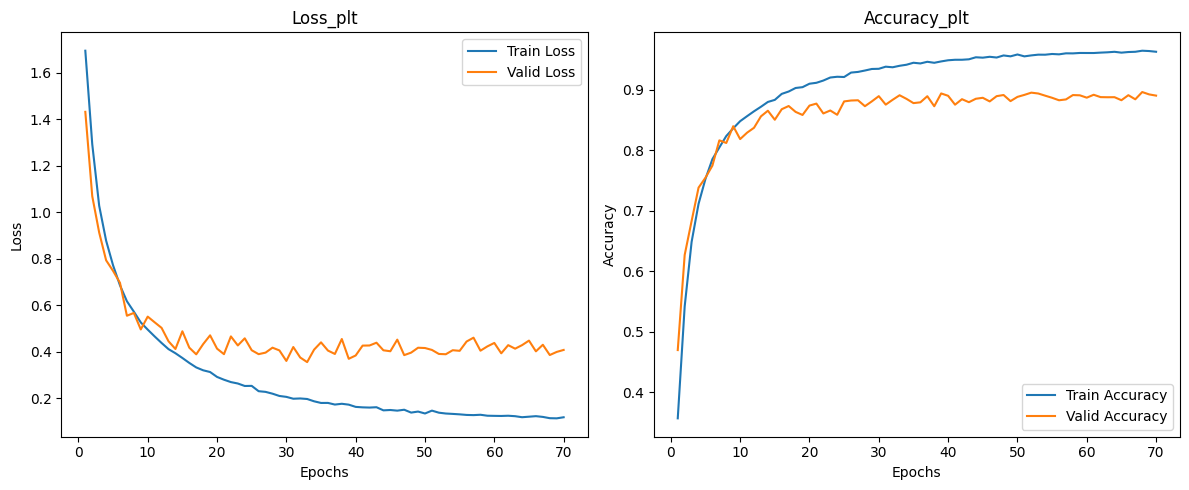

In [9]:
# 基于Alex改造的resnet + dropout! + bn + weight decay(Adam) + 进一步减轻全连接 + 采用自适应池化 + 减弱数据增强
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time

# 残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)  
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)  # 添加归一化层
        
        # 用于调整输入和输出的维度
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)  # 应用归一化
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)  # 应用归一化
        return self.relu(out + self.shortcut(x))  # 残差

# 带有残差连接的 AlexNet 模型
class RRRR(nn.Module):
    def __init__(self):
        super(RRRR, self).__init__()
        self.features = nn.Sequential(
            ResidualBlock(3, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 192),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(192, 384),
            ResidualBlock(384, 256),
            ResidualBlock(256, 256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((1, 1))  # 使用自适应平均池化
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 64),  # 修改全连接层输入尺寸
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # 添加 dropout 层
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256)  # 修改展平后的尺寸
        x = self.classifier(x)
        return x
# 超参数
batch_size = 128
lr = 0.001
epochs = 70

# 数据整理
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) 
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='Datasets', train=False, download=True, transform=transform_test)

# 划分数据集
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_subset, valid_subset = random_split(train_dataset, [train_size, valid_size])

train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=valid_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
train_data_size = len(train_subset)
valid_data_size = len(valid_subset)
test_data_size = len(test_dataset)

# 模型训练

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RRRR().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr,  weight_decay=1e-4)
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []
def train(num_epochs):
    for epoch in range(num_epochs):
        model.train()  # 切换到训练模式
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * images.size(0)
        
        valid_loss = 0.0
        valid_acc = 0.0
        with torch.no_grad():
            model.eval()  # 切换到验证模式
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * images.size(0)
                
                _, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * images.size(0)
        
        avg_train_loss = train_loss / train_data_size
        avg_train_acc = train_acc / train_data_size
        avg_valid_loss = valid_loss / valid_data_size
        avg_valid_acc = valid_acc / valid_data_size

        print(
            f"Epoch [{epoch + 1}/{num_epochs}]"
            f" Training: Loss: {avg_train_loss:.4f}, Accuracy: {avg_train_acc * 100:.2f}%, "
            f"Validation: Loss: {avg_valid_loss:.4f}, Accuracy: {avg_valid_acc * 100:.2f}%"
        )
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        valid_losses.append(avg_valid_loss)
        valid_accuracies.append(avg_valid_acc)
        
        

def test():
    model.eval()  # 切换到评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# 执行训练和评估
all_start = time.time() # 计时
train(epochs)
test()
all_end = time.time() # 计时结束
all_time = round(all_end - all_start)
print("All Time: {:d} 分 {:d} 秒".format(all_time // 60, all_time % 60))

# 绘制损失曲线
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss_plt')
plt.legend()

# 绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), valid_accuracies, label='Valid Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy_plt')
plt.legend()

plt.tight_layout()
plt.show()